# Advanced Structure Similarity Analysis

This advanced example will illustrate how to use Melodia to compare structural similarities between protein family members. Curvature and torsion are very sensitive to small changes in the backbone geometry and are also rotational invariant. Thus, they are robust descriptors for finding the protein family building blocks.

In [1]:
# Uncomment for running in Google Colab
#!pip install melodia-py

In [2]:
import dill
import warnings

import pandas as pd
import melodia_py as mel
import seaborn as sns
import matplotlib.pyplot as plt

from os import path
from math import sqrt
from sklearn.preprocessing import StandardScaler
from Bio.PDB.PDBExceptions import PDBConstructionWarning

warnings.filterwarnings("ignore", category=PDBConstructionWarning)

The first step is to read and process an alignment file. See **Notebook 2** for more information about this process.

In [3]:
# Uncomment for running in Google Colab
#! curl -OJL https://github.com/rwmontalvao/melodia_py/raw/main/examples/model.ali
#! curl -OJL https://github.com/rwmontalvao/melodia_py/raw/main/examples/1cdoa.pdb
#! curl -OJL https://github.com/rwmontalvao/melodia_py/raw/main/examples/1d1ta.pdb
#! curl -OJL https://github.com/rwmontalvao/melodia_py/raw/main/examples/1teha.pdb
#! curl -OJL https://github.com/rwmontalvao/melodia_py/raw/main/examples/2ohxa.pdb
#! curl -OJL https://github.com/rwmontalvao/melodia_py/raw/main/examples/3huda.pdb

In [4]:
# Dill can be used for storage
if path.exists('model.dill'):
    with open('model.dill', 'rb') as file:
        align = dill.load(file)
else:
    align = mel.parser_pir_file('model.ali')
    with open('model.dill', 'wb') as file:
        dill.dump(align, file)

In [5]:
# Create a Pandas DataFrame for only the Curvature and Torsion descriptors
df = mel.dataframe_from_alignment(align=align, keys=['curvature', 'torsion'])
df.head()

,seq_1cdoa,curvature_1cdoa,torsion_1cdoa,seq_1d1ta,curvature_1d1ta,torsion_1d1ta,seq_1teha,curvature_1teha,torsion_1teha,seq_2ohxa,curvature_2ohxa,torsion_2ohxa,seq_3huda,curvature_3huda,torsion_3huda
0,A,0.911238,0.110831,G,1.047306,0.110002,-,0.000000,0.000000,S,0.858952,0.103759,S,0.794220,0.107699
1,T,0.911238,0.110831,T,1.047306,0.110002,-,0.000000,0.000000,T,0.858952,0.103759,T,0.794220,0.107699
2,V,0.434979,0.044909,A,0.454057,0.032614,A,0.644497,0.121356,A,0.505272,0.043087,A,0.463674,0.074985
3,G,0.822893,0.062217,G,0.801947,0.048148,N,0.644497,0.121356,G,0.697603,0.059488,G,0.572861,0.099983
4,K,0.390131,-0.000838,K,0.504131,-0.012812,E,0.535522,-0.003564,K,0.366238,-0.007581,K,0.347366,0.004505


In [6]:
# Get the ids for all the sequences with a structure file
ids = [record.description.split(':')[1] for record in align if 'structure' in record.description]
ids

['1cdoa', '1d1ta', '1teha', '2ohxa', '3huda']

In [7]:
# Creat a copy
dfa = df.copy()

# Define the scikit-learn autoscaler
autoscaler = StandardScaler()

# Create a list for the feature to scale
features = []
for id in ids:
    features.append(f'curvature_{id}')
    features.append(f'torsion_{id}')

# Apply the autoscaler
dfa[features] = autoscaler.fit_transform(dfa[features])

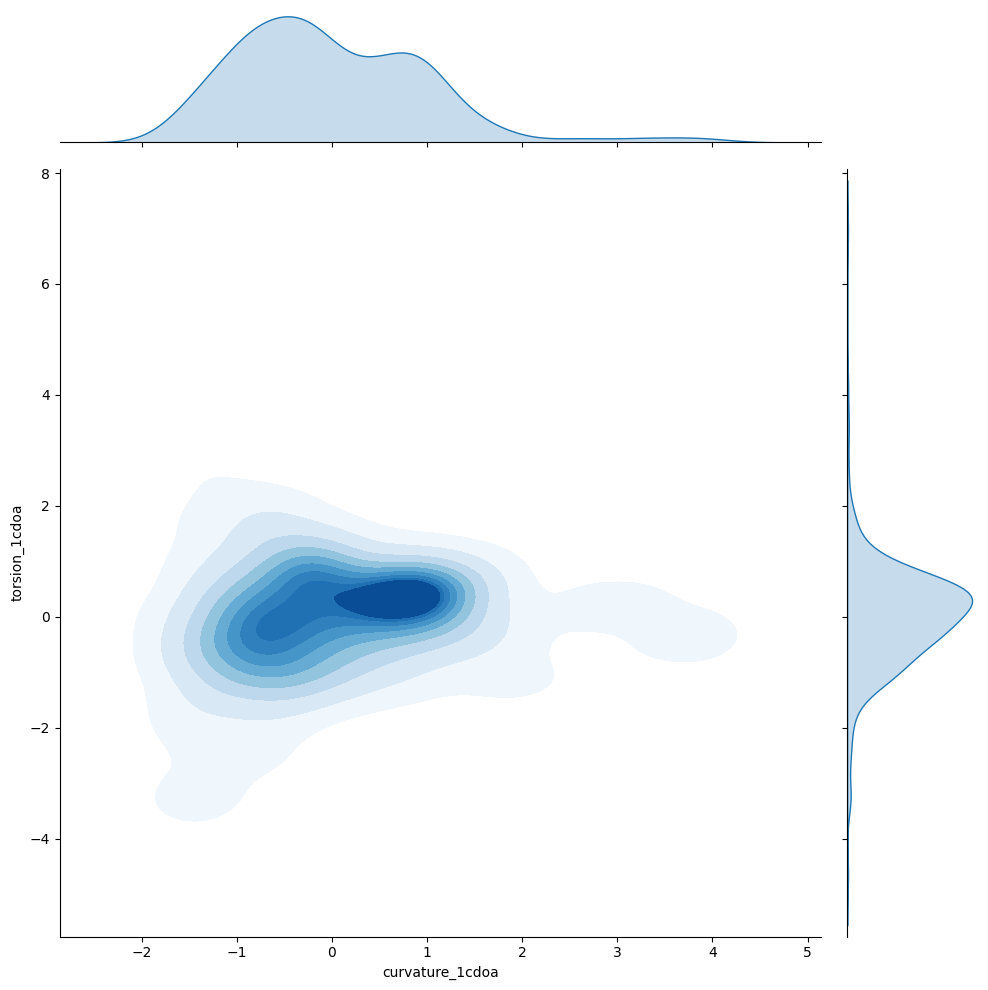

In [8]:
# Plot the scaled data for the 1st protein
cmap = sns.color_palette("Blues", as_cmap=True)
sns.jointplot(x=features[0], y=features[1], data=dfa, kind='kde', cmap=cmap, height=10, fill=True);

In [9]:
# Copy the ids and POP one of the proteins as the base
tags = ids.copy()
base = tags.pop()
base

'3huda'

In this case, we will compare the *base protein* with **all** the other *aligned proteins*. Our idea is to find regions of high similarity with the base protein in all the other proteins.

In [10]:
# Define the Euclidian distance between the base protein and the cmp protein
def dist(row):
    d = (row[f'curvature_{base}'] - row[f'curvature_{cmp}'])**2 + (row[f'torsion_{base}'] - row[f'torsion_{cmp}'])**2
    return sqrt(d)

# Create new columns with the Euclidian distance
columns = []
for cmp in tags:    
    dfa[f'{base}_{cmp}'] = dfa.apply(dist, axis=1)
    columns.append(f'{base}_{cmp}')

In [11]:
dfa[[i for i in dfa.columns if 'seq' in i] + columns]

,seq_1cdoa,seq_1d1ta,seq_1teha,seq_2ohxa,seq_3huda,3huda_1cdoa,3huda_1d1ta,3huda_1teha,3huda_2ohxa
0,A,G,-,S,S,0.382061,1.197084,4.703142,0.240975
1,T,T,-,T,T,0.382061,1.197084,4.703142,0.240975
2,V,A,A,A,A,0.303477,0.213023,0.903078,0.218253
3,G,G,N,G,G,1.232148,1.162809,0.243610,0.651725
4,K,K,E,K,K,0.204232,0.834923,0.993282,0.099011
...,...,...,...,...,...,...,...,...,...
370,T,T,T,T,T,0.162708,1.118075,0.424997,0.453241
371,V,V,V,I,V,1.501029,1.681185,1.092273,2.061667
372,L,L,V,L,L,0.092902,0.061910,0.418808,0.077929
373,S,T,K,T,T,0.609176,0.417938,0.798365,0.077819


In [12]:
# Select the 1st protein for comparison
column = columns[0]
df_clust = dfa[column].copy().reset_index()
df_clust.head()

,index,3huda_1cdoa
0,0,0.382061
1,1,0.382061
2,2,0.303477
3,3,1.232148
4,4,0.204232


***
This simple algorithm selects regions with similarity under the specified threshold. The algorithm ensures that those regions are at least three residues long.
***

In [13]:
import more_itertools as mit

threshold = 0.5

clabels = [0 if x > threshold else 1 for x in list(df_clust[column])]

similar = [i for i, label in enumerate(clabels) if label > 0]

regions = [list(group) for group in mit.consecutive_groups(similar)]

for i, block in enumerate(regions):
    if len(block) >= 3:
        value = i
    else:
        value = 0
    for j in block:
        clabels[j] = value

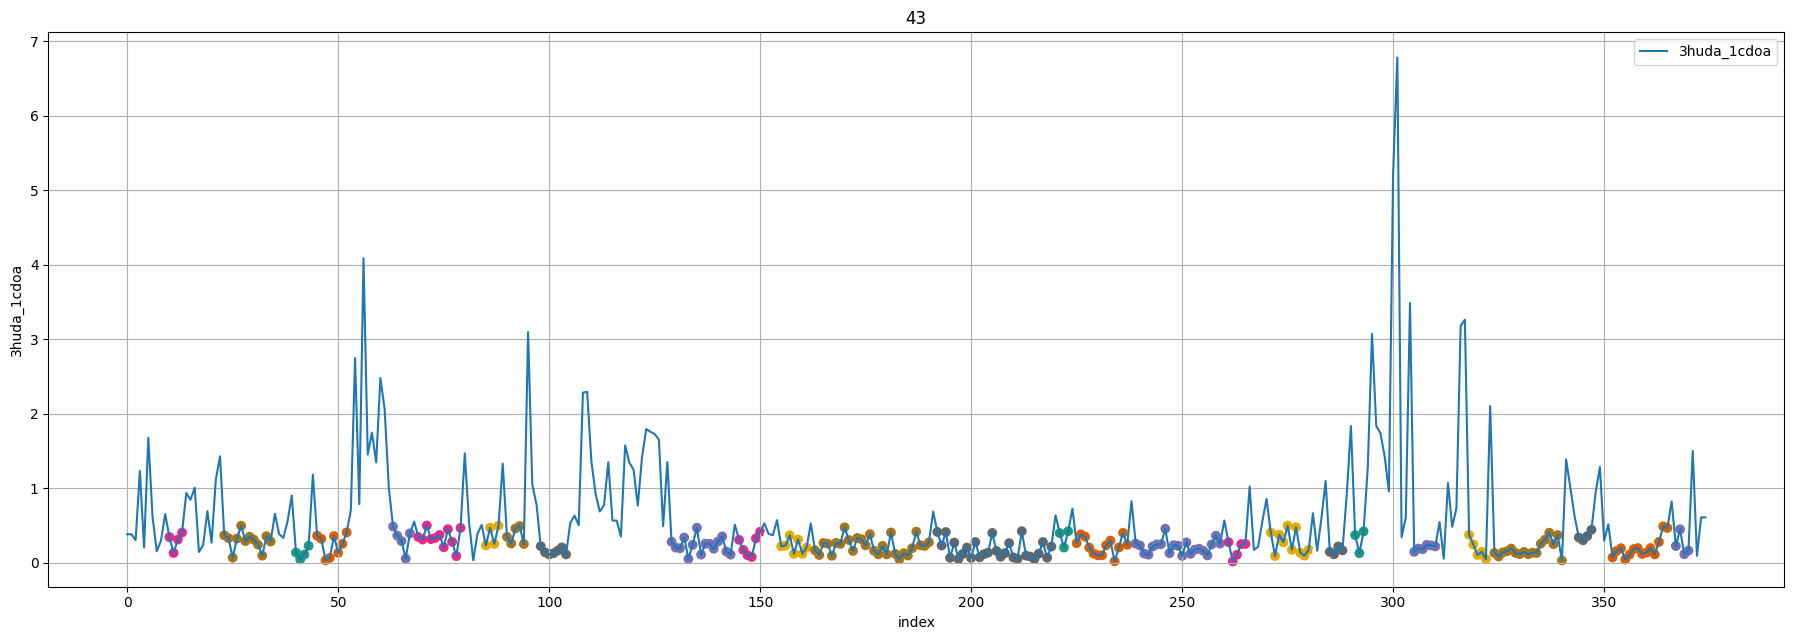

In [14]:
# Display the similar regions between the two proteins
n_clusters = max(clabels)+1

color_palette = sns.color_palette('Dark2', n_clusters)
cluster_colors = [color_palette[x] if x > 0 else (1.0, 1.0, 1.0) for x in clabels]

ax = df_clust.plot.scatter(x='index', y=column, s=50, linewidth=0, c=cluster_colors, alpha=1.0, figsize=(6.4*3.5, 4.8*1.5));
df_clust.plot(x='index', y=column, figsize=(6.4*3.5, 4.8*1.5), ax=ax)
plt.title(f'{n_clusters}')
plt.grid()